# Run

## Imports

In [14]:
import cv2
import numpy as np
from src.ocr.detection.craft.craft import CRAFT
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Load Img & Resize

In [15]:
def load_image(image_path):
    img_color = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)
    return img_color, img_gray


def resize(img, canvas_size, interpolation, mag_ratio=1.0):
    height, width = img.shape

    # set target image size
    target_size = mag_ratio * max(height, width)

    # set original image size
    if target_size > canvas_size:
        target_size = canvas_size

    ratio = target_size / max(height, width)    

    target_h, target_w = int(height * ratio), int(width * ratio)
    proc = cv2.resize(img, (target_w, target_h), interpolation=interpolation)

    # make canvas and paste image (pad to even size)
    target_h2, target_w2 = target_h, target_w
    if target_h % 2 != 0:
        target_h2 = target_h + 1
    if target_w % 2 != 0:
        target_w2 = target_w + 1
    resized = np.zeros((target_h2, target_w2), dtype=np.float32)
    resized[0:target_h, 0:target_w] = proc
    target_h, target_w = target_h2, target_w2

    size_heatmap = (int(target_w/2), int(target_h/2))

    return resized, ratio, size_heatmap

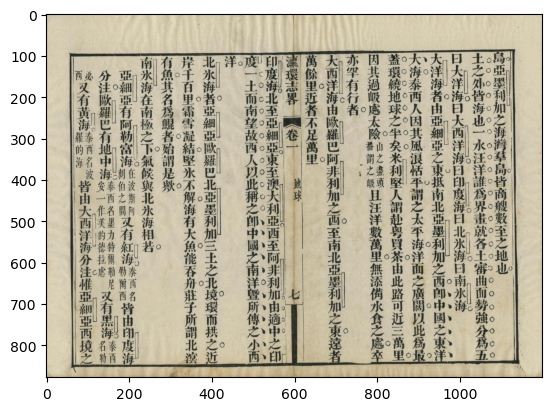

In [16]:
img_path = 'data/examples/ying_huan_zhi_lue.jpg'
craft_model = CRAFT()
canvas_size=2400
mag_ratio=10.0

# Load image
img_color,img_gray = load_image(img_path)
plt.imshow(img_color)
plt.show()

# Define empty global text heatmap
H, W = img_gray.shape[:2]

# Resize image
resized_image, target_ratio, size_heatmap  = resize(img_gray, canvas_size=canvas_size, interpolation=cv2.INTER_LINEAR, mag_ratio=mag_ratio)
ratio_h = ratio_w = 1 / target_ratio
    

## Run Craft

In [17]:
def detect_text_regions(craft_model, image):
    prediction = craft_model.detect_text(image)
    return prediction['heatmaps']['text_score_heatmap'], prediction['heatmaps']['link_score_heatmap']

def normalize_hmap(text_hmap):
    if text_hmap.dtype != np.float32:
        text_hmap = text_hmap.astype(np.float32) / 255.0
    return text_hmap

In [13]:
# Apply craft to get text scores
text_hmap, link_hmap = detect_text_regions(craft_model, resized_image)

# Normalize text_hmap to [0,1] if needed
heatmap = normalize_hmap(text_hmap)
l_heatmap = normalize_hmap(link_hmap)

plt.imshow(heatmap, cmap='jet')
plt.show()

AttributeError: 'CRAFT' object has no attribute 'detect_text'

## Watershed

In [22]:
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

# This is an alternative watershed implementation using skimage (local maxima)
def watershed_skimage(gray_heatmap, min_distance=1):
    # Ensure dtype is uint8 in [0, 255]
    if gray_heatmap.dtype != np.uint8:
        gray_heatmap = (np.clip(gray_heatmap, 0, 1) * 255).astype(np.uint8)

    # Threshold the heatmap to create a binary mask
    thresh = cv2.threshold(gray_heatmap, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # Find local maxima in the heatmap
    local_max = peak_local_max(
        gray_heatmap, 
        min_distance=min_distance, 
        labels=thresh,
        exclude_border=False
    )

    # Create marker image for watershed
    markers_mask = np.zeros_like(gray_heatmap, dtype=bool)
    markers_mask[tuple(local_max.T)] = True
    markers = ndimage.label(markers_mask, structure=np.ones((3, 3)))[0]

    # Apply the watershed algorithm on the inverted heatmap
    labels = watershed(-gray_heatmap, markers, mask=thresh)

    return labels

# This is the watershed as supposedly used to train CRAFT (threshold-based)
def watershed_opencv(region_score):
    fore = np.uint8(region_score > 0.75)
    back = np.uint8(region_score < 0.05)
    unknown = 1 - (fore + back)
    ret, markers = cv2.connectedComponents(fore)
    markers += 1
    markers[unknown == 1] = 0

    labels = watershed(-region_score, markers)
    # get only foreground labels
    labels = labels * (labels > 1)
    return labels

def double_image_superpixel(img):
    """
    Resize image so each pixel becomes a 2x2 block of same value.
    """
    return np.repeat(np.repeat(img, 2, axis=0), 2, axis=1)

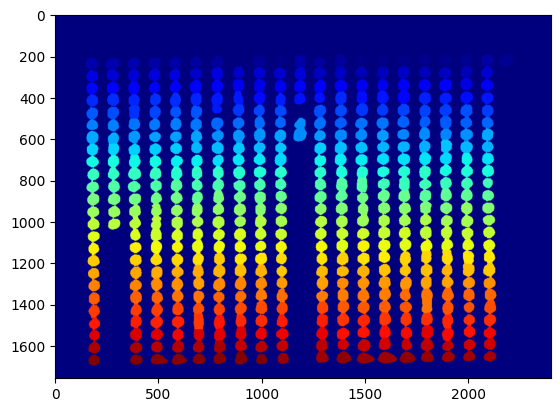

In [ ]:
# Apply watershed
labels_ws = watershed_skimage(heatmap, min_distance=20)
# Double the size to match original image (as CRAFT outputs half-size heatmaps)
labels_ws = double_image_superpixel(labels_ws)

# Visualize results
plt.imshow(labels_ws, cmap='jet')
plt.show()

## Connected Components

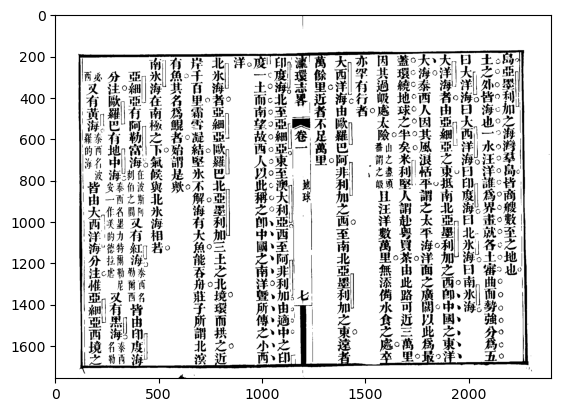

In [18]:
from skimage.filters import threshold_otsu

# Binarize image using Otsu's method
thresh = threshold_otsu(resized_image)
binary_img = resized_image < thresh
plt.imshow(binary_img, cmap='gray_r')
plt.show()


In [19]:
### Optional: Deglue connected components from black box
# Morphological opening with a vertical kernel to close gaps
mask = (255*binary_img).astype(np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE,  np.ones((1, 20), np.uint8))

# Top-hat transform with a very long horizontal kernel to eliminate long horizontal structures
mask = cv2.morphologyEx(mask, cv2.MORPH_TOPHAT, np.ones((1, 150), np.uint8))

# Apply mask to 
binary_img = binary_img  & ((mask.astype(bool)))

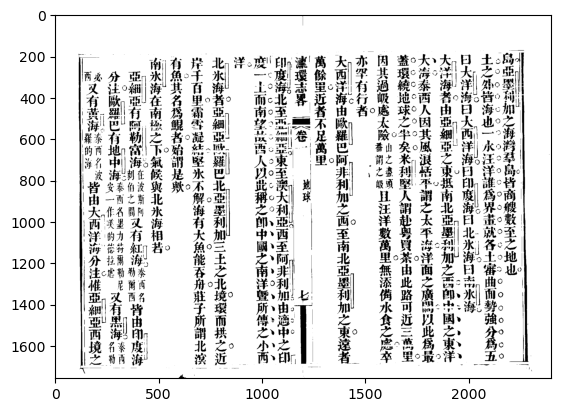

In [20]:
plt.imshow(binary_img, cmap='gray_r')
plt.show()

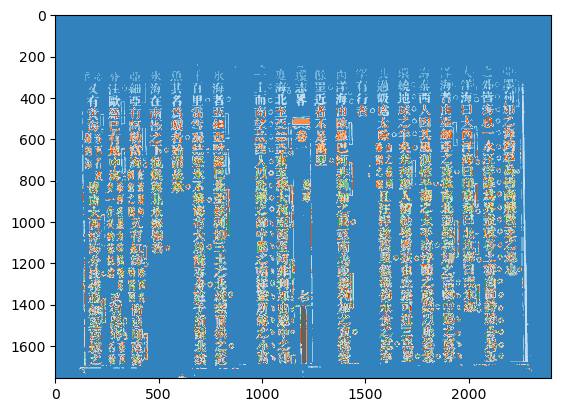

In [23]:
# Connected components
labels_ch = ndimage.label(binary_img)[0]
plt.imshow(labels_ch, cmap='tab20c')
plt.show()

## Assign Watershed Labels to Connected Components

In [ ]:
def assign_connected_components_to_watershed(labels_ws, labels_ch):
    """
    Efficiently assign connected components to watershed regions based on overlap.
    
    Parameters
    ----------
    labels_ws : 2D array
        Watershed labels
    labels_ch : 2D array  
        Connected component labels
        
    Returns
    -------
    assignments : 1D array
        For each CC label, the assigned watershed label
    overlap_matrix : 2D array
        Overlap counts between watershed and CC labels
    """
    # Create flattened views for vectorized operations
    ws_flat = labels_ws.flatten()
    ch_flat = labels_ch.flatten()
    
    # Only consider pixels where both have non-zero labels
    valid_mask = (ws_flat > 0) & (ch_flat > 0)
    ws_valid = ws_flat[valid_mask]
    ch_valid = ch_flat[valid_mask]
    
    # Count overlaps using numpy's advanced indexing
    max_ws = labels_ws.max()
    max_ch = labels_ch.max()
    overlap_matrix = np.zeros((max_ws + 1, max_ch + 1), dtype=int)
    
    # Vectorized counting using np.add.at
    np.add.at(overlap_matrix, (ws_valid, ch_valid), 1)
    
    # Assign each CC to the watershed region with maximum overlap
    assignments = np.argmax(overlap_matrix, axis=0)
    
    return assignments, overlap_matrix

In [ ]:
assignments, overlap_counts = assign_connected_components_to_watershed(labels_ws, labels_ch)

# Now assignments[cc_label] gives the watershed label for that connected component
# Create the final assignment map
cc_to_ws_map = np.zeros_like(labels_ch)
for cc_label in range(1, labels_ch.max() + 1):
    ws_label = assignments[cc_label]
    if ws_label > 0:  # Skip if no assignment found
        cc_to_ws_map[labels_ch == cc_label] = ws_label

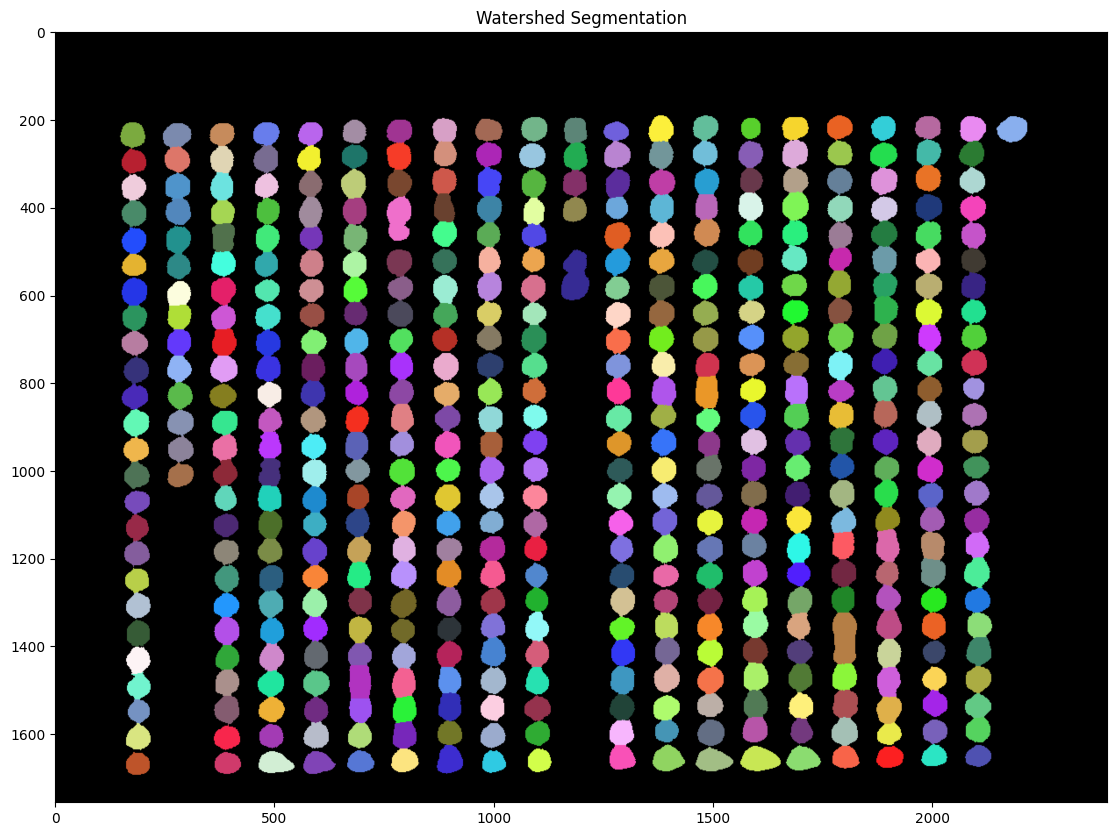

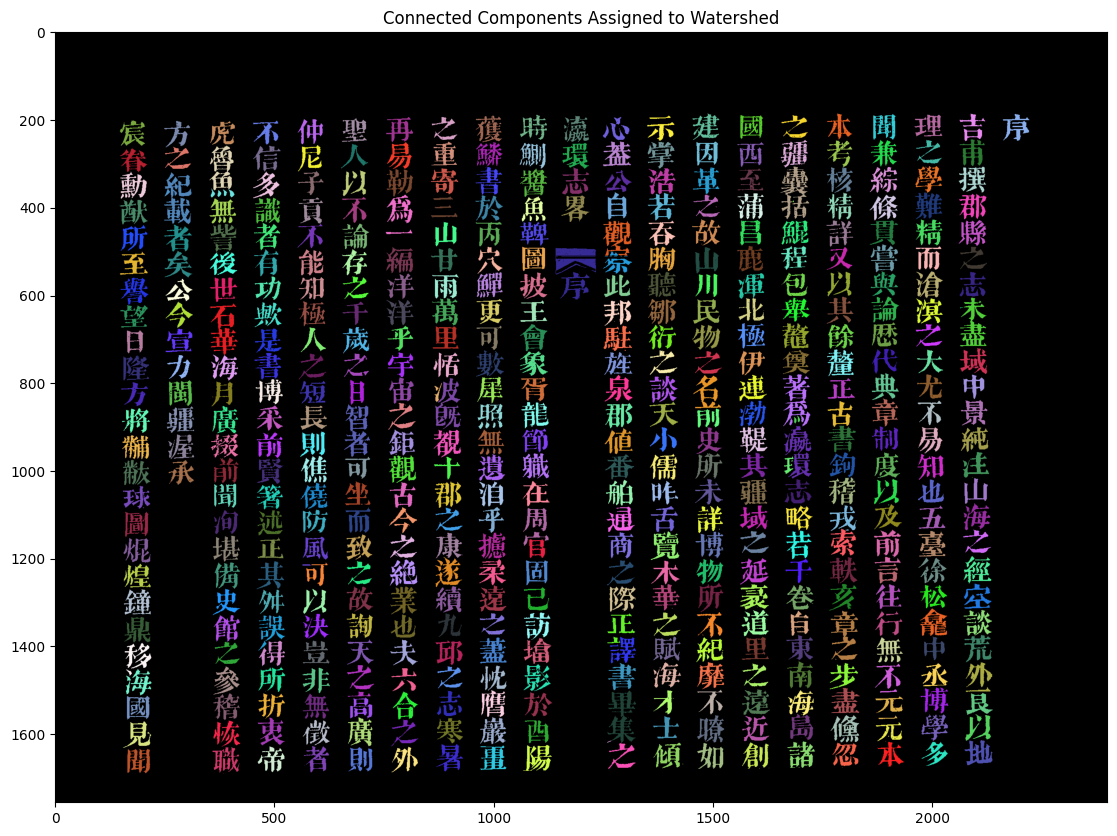

In [ ]:
# Visualize final assignment
# Assign random RGB colors to each watershed label
unique_ws_labels = np.unique(labels_ws)
vis_final_ws = np.zeros((*labels_ws.shape, 3), dtype=np.uint8)
vis_final_cc = np.zeros((*labels_ch.shape, 3), dtype=np.uint8)
for lbl in unique_ws_labels:
    if lbl == 0:
        continue
    color = np.random.randint(30, 255, size=3)
    vis_final_ws[labels_ws == lbl] = color
    vis_final_cc[cc_to_ws_map == lbl] = color

plt.figure(figsize=(16, 10))
plt.imshow(vis_final_ws)
plt.title("Watershed Segmentation")
plt.show()
plt.figure(figsize=(16, 10))
plt.imshow(vis_final_cc)
plt.title("Connected Components Assigned to Watershed")
plt.show()